In [2]:
from google.colab import files
import os

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

!unzip -q chest-xray-pneumonia.zip -d data

print("Dataset downloaded and unziped succesfully!")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:21<00:00, 250MB/s]
100% 2.29G/2.29G [00:21<00:00, 114MB/s]
Lapdance@2233
Dataset downloaded and unziped succesfully!


In [4]:
import shutil
import random

def create_subset(source_dir, target_dir, ratio=0.5):
  if not os.path.exists(target_dir):
    os.makedirs(target_dir)

  for category in ["NORMAL", "PNEUMONIA"]:
    src_path = os.path.join(source_dir, category)
    dst_path = os.path.join(target_dir, category)
    if not os.path.exists(dst_path):
      os.makedirs(dst_path)

    all_images = os.listdir(src_path)
    random.shuffle(all_images)

    subset_size = int(len(all_images) * ratio)
    subset_images = all_images[:subset_size]

    for img in subset_images:
      shutil.copy(os.path.join(src_path, img), os.path.join(dst_path, img))

  print(f"Created a {int(ratio*100)}% subset in {target_dir}")

create_subset('data/chest_xray/train', 'working_data/train', ratio=0.5)
create_subset('data/chest_xray/test', 'working_data/test', ratio=1.0)

Created a 50% subset in working_data/train
Created a 100% subset in working_data/test


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #ImageNet Standards
])

train_dataset = datasets.ImageFolder(root="working_data/train", transform = data_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers = 2
)

print(f"Classes Found : {train_dataset.classes}")
print(f"Mapping : {train_dataset.class_to_idx}")

images, labels = next(iter(train_loader))
print(f"Batch Shape: {images.shape}")

Classes Found : ['NORMAL', 'PNEUMONIA']
Mapping : {'NORMAL': 0, 'PNEUMONIA': 1}
Batch Shape: torch.Size([32, 3, 224, 224])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [7]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(weights='DEFAULT')

for param in model.parameters():
  param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

print(f"model is ready on {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


model is ready on cuda


In [13]:
import torch.optim as optim
from tqdm.notebook import tqdm


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

def train_engine(model, train_loader,criterion, optimizer, device, epochs = 5):

  history = []
  master_pbar = tqdm(range(epochs), desc="Overall Training", position=0)

  for epoch in master_pbar:
    model.train()
    running_loss = 0.0

    batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batch",position=1, leave=False)

    for images, labels in batch_pbar:

      images =  images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      current_batch_loss = running_loss / (batch_pbar.n + 1)
      batch_pbar.set_postfix(final_loss = f"{current_batch_loss:.4f}")

    epoch_final_loss = running_loss / len(train_loader)
    history.append(epoch_final_loss)
    master_pbar.set_postfix(last_epoch_loss = f"{epoch_final_loss:.4f}")

  print("\n" + "="*30)
  print("      TRAINING SUMMARY")
  print("="*30)
  for i, loss in enumerate(history):
      print(f"Epoch {i+1}: Final Loss = {loss:.4f}")
  print("="*30)

  return history

loss_history = train_engine(model, train_loader, criterion, optimizer, device, epochs = 5)

Overall Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 2:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 3:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 4:   0%|          | 0/82 [00:00<?, ?batch/s]

Epoch 5:   0%|          | 0/82 [00:00<?, ?batch/s]


      TRAINING SUMMARY
Epoch 1: Final Loss = 0.1425
Epoch 2: Final Loss = 0.1182
Epoch 3: Final Loss = 0.1298
Epoch 4: Final Loss = 0.1160
Epoch 5: Final Loss = 0.1060


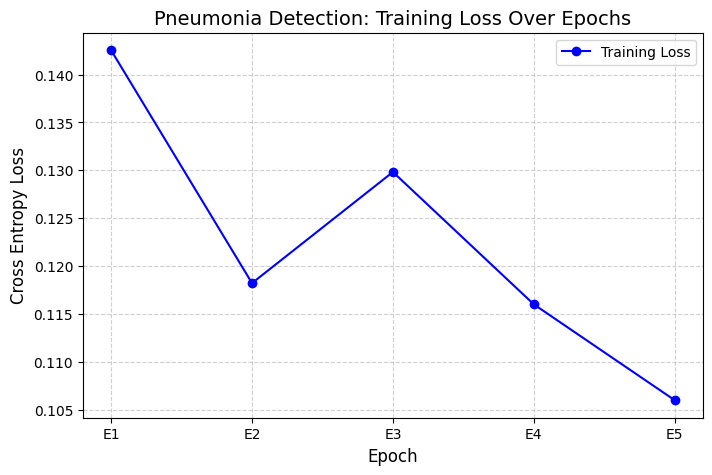

In [17]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history, marker='o', linestyle='-', color='b', label="Training Loss")

    plt.title("Pneumonia Detection: Training Loss Over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Cross Entropy Loss", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.xticks(range(len(history)), [f"E{i+1}" for i in range(len(history))])
    plt.show()

plot_loss(loss_history)

In [19]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root = "working_data/test", transform=test_transforms)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print(f"Test images found : {len(test_dataset)}")

Test images found : 624


In [20]:
def run_evaluation(model, loader, device):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in tqdm(loader, desc="Evaluationg"):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      _, predicted = torch.max(outputs, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"\nFinal Test Accuracy: {accuracy:.2f}%")
  return accuracy

final_acc = run_evaluation(model, test_loader, device)

Evaluationg:   0%|          | 0/20 [00:00<?, ?it/s]


Final Test Accuracy: 81.57%


In [26]:
!pip install grad-cam --upgrade

In [34]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def run_grad_cam(model, input_tensor, original_img_path):
    # Change target_layers to model.layer4[-1], which is the last convolutional layer.
    target_layers = [model.layer4[-1]]

    cam = GradCAM(model=model, target_layers=target_layers)


    targets = [ClassifierOutputTarget(1)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    img = np.array(Image.open(original_img_path).convert('RGB')).astype(np.float32) / 255.0

    img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((224, 224))) / 255.0

    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title("Grad-CAM: Where the model is looking")
    plt.show()

True Label: PNEUMONIA


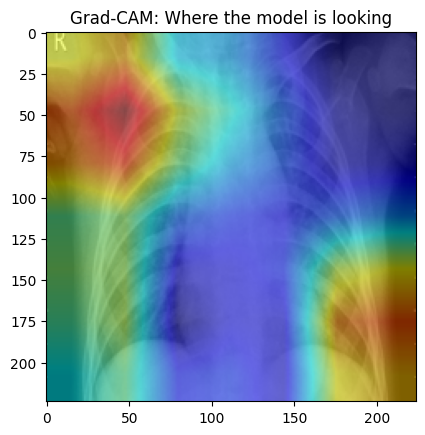

In [41]:
import random

img_idx = random.randint(0, len(test_dataset) - 1)
input_image, label = test_dataset[img_idx]

input_tensor = input_image.unsqueeze(0).to(device).requires_grad_(True)

img_path, _ = test_dataset.samples[img_idx]

print(f"True Label: {'PNEUMONIA' if label == 1 else 'NORMAL'}")

run_grad_cam(model, input_tensor, img_path)

## Now trying to Train the whole Dataset.

In [46]:
import torch.optim as optim
from torch.optim import lr_scheduler

full_train_dataset = datasets.ImageFolder(root="data/chest_xray/train", transform=data_transforms)
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True, num_workers=2)

full_test_dataset = datasets.ImageFolder(root='data/chest_xray/test', transform=test_transforms)
full_test_loader = DataLoader(full_test_dataset, batch_size=32, shuffle=False, num_workers=2)

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma = 0.1)

print(f"Ready! Training on {len(full_train_dataset)} images, Testing on {len(full_test_dataset)} images.")

Ready! Training on 5216 images, Testing on 624 images.


In [47]:
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=10):
    stats = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", unit="batch", position=0)

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=f"{train_loss/(pbar.n+1):.4f}")

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

        avg_train = train_loss / len(train_loader)
        avg_test = test_loss / len(test_loader)

        stats['train_loss'].append(avg_train)
        stats['test_loss'].append(avg_test)

        scheduler.step()

        print(f"Epoch {epoch+1} Summary: Train Loss: {avg_train:.4f} | Test Loss: {avg_test:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    return stats

full_stats = train_and_validate(model, full_train_loader, full_test_loader, criterion, optimizer, exp_lr_scheduler, device, epochs=10)

Epoch 1/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 1 Summary: Train Loss: 0.0996 | Test Loss: 0.5014 | LR: 0.001000


Epoch 2/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 2 Summary: Train Loss: 0.0972 | Test Loss: 0.7361 | LR: 0.001000


Epoch 3/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 3 Summary: Train Loss: 0.0999 | Test Loss: 0.5513 | LR: 0.001000


Epoch 4/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 4 Summary: Train Loss: 0.1038 | Test Loss: 0.6870 | LR: 0.001000


Epoch 5/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 5 Summary: Train Loss: 0.0919 | Test Loss: 0.4341 | LR: 0.001000


Epoch 6/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 6 Summary: Train Loss: 0.1022 | Test Loss: 0.5650 | LR: 0.001000


Epoch 7/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 7 Summary: Train Loss: 0.0985 | Test Loss: 0.6040 | LR: 0.000100


Epoch 8/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 8 Summary: Train Loss: 0.0902 | Test Loss: 0.5446 | LR: 0.000100


Epoch 9/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 9 Summary: Train Loss: 0.0889 | Test Loss: 0.5579 | LR: 0.000100


Epoch 10/10 [Train]:   0%|          | 0/163 [00:00<?, ?batch/s]

Epoch 10 Summary: Train Loss: 0.0931 | Test Loss: 0.5531 | LR: 0.000100


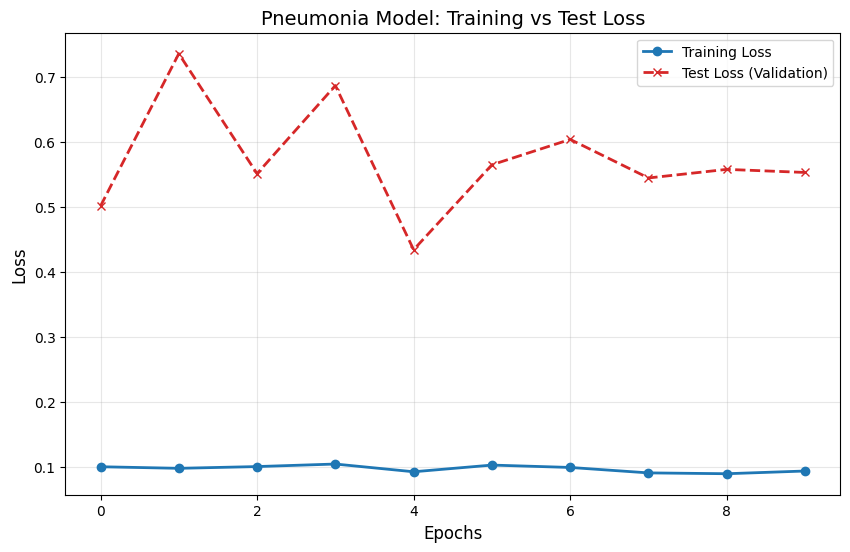

In [48]:
import matplotlib.pyplot as plt

def plot_learning_curves(stats):
    plt.figure(figsize=(10, 6))
    plt.plot(stats['train_loss'], label='Training Loss', color='#1f77b4', linewidth=2, marker='o')
    plt.plot(stats['test_loss'], label='Test Loss (Validation)', color='#d62728', linestyle='--', linewidth=2, marker='x')
    plt.title('Pneumonia Model: Training vs Test Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_learning_curves(full_stats)

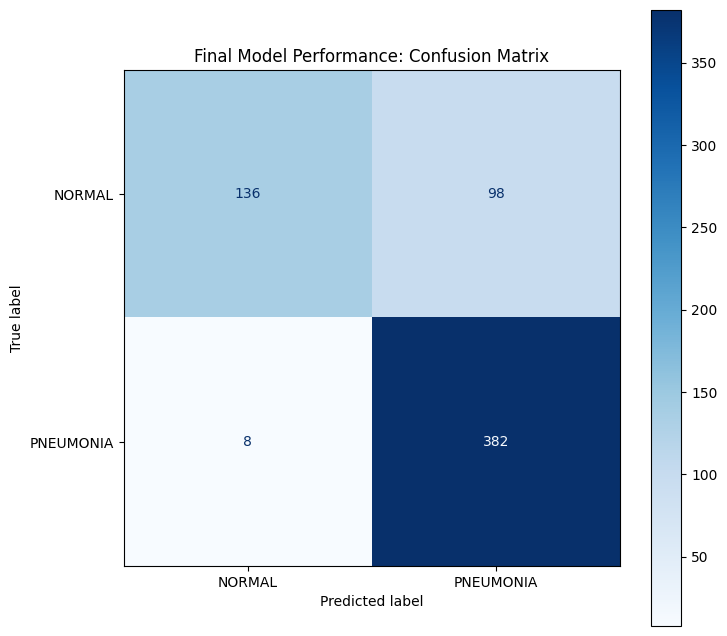

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, loader, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title('Final Model Performance: Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, full_test_loader, device)

In [58]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def calculate_final_metrics(model, loader, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    pre = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("="*30)
    print(f"FINAL TEST METRICS")
    print("="*30)
    print(f"Accuracy:  {acc*100:.2f}%")
    print(f"Recall:    {rec*100:.2f}% (Safety Metric)")
    print(f"Precision: {pre*100:.2f}%")
    print(f"F1-Score:  {f1*100:.2f}%")
    print("="*30)

calculate_final_metrics(model, full_test_loader, device)

FINAL TEST METRICS
Accuracy:  83.01%
Recall:    97.95% (Safety Metric)
Precision: 79.58%
F1-Score:  87.82%


In [64]:
def get_error_indices(model, loader, device):
  fn_indices = []

  model.eval()

  current_idx = 0
  with torch.no_grad():
    for images, labels in loader:
      images = images.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)

      preds = preds.cpu().numpy()
      labels = labels.numpy()

      for i in range(len(preds)):
        if labels[i] == 1 and preds[i] == 0:
          fn_indices.append(current_idx)
        current_idx += 1

  return fn_indices

fn_list = get_error_indices(model, full_test_loader, device)
print(f"Indices of False Negatives: {fn_list}")

Indices of False Negatives: [254, 287, 317, 363, 391, 404, 479, 525]


Analyzing Index 391: Should be Pneumonia, but model said Normal.


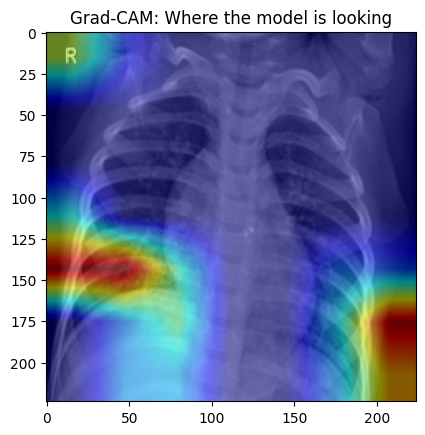

In [71]:
error_idx = fn_list[4]

input_image, label = full_test_dataset[error_idx]
input_tensor = input_image.unsqueeze(0).to(device).requires_grad_(True)
img_path, _ = full_test_dataset.samples[error_idx]

print(f"Analyzing Index {error_idx}: Should be Pneumonia, but model said Normal.")

run_grad_cam(model, input_tensor, img_path)

True Label: PNEUMONIA


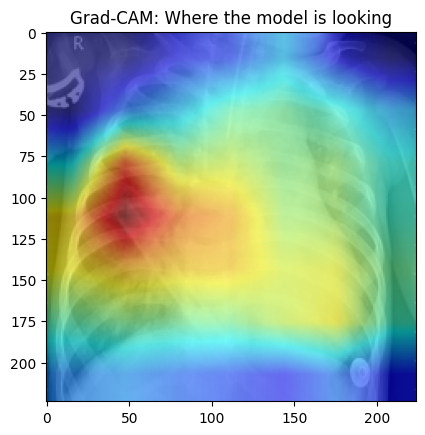

In [67]:
import random

img_idx = random.randint(0, len(test_dataset) - 1)
input_image, label = test_dataset[img_idx]

input_tensor = input_image.unsqueeze(0).to(device).requires_grad_(True)

img_path, _ = test_dataset.samples[img_idx]

print(f"True Label: {'PNEUMONIA' if label == 1 else 'NORMAL'}")

run_grad_cam(model, input_tensor, img_path)

In [72]:
torch.save(model.state_dict(), "pneumonia_final_resnet18.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')